In [ ]:
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import os
from tensorflow import keras
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import cv2
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras import layers, losses
import arviz as az

import pymc3 as pm
import theano.tensor as tt
import theano
from skimage.measure import compare_psnr
from PIL import Image
from skimage.measure import compare_ssim


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

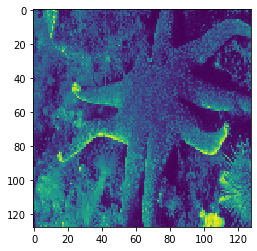

In [ ]:
data_path = 'D:/data/DIV2K Realistic Wild/Train'
data_dir_list = os.listdir(data_path)
img_data_list=[]
img_list=os.listdir(data_path+'/'+ "HR")
i=0
for img in img_list:
    input_img=cv2.imread(data_path + '/'+ "HR" + '/'+ img )
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(128,128))  #model 1 and 2 and 3
    img_data_list.append(input_img_resize)
    if i==50:
        break
    i+=1
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
plt.imshow( img_data[0])
#img_data = img_data.reshape(img_data.shape[0], 128,128)

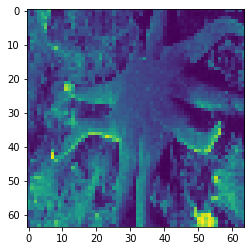

In [ ]:
data_path = 'D:/data/DIV2K Realistic Wild/Train'
lr_data_list=[]
lr_list=os.listdir(data_path+'/'+ "LR")
i=0
for img in lr_list:
    input_img=cv2.imread(data_path + '/'+ "LR" + '/'+ img )
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(64,64))  #model 1 and 2 and 3
    lr_data_list.append(input_img_resize)
    if i==50:
        break
    i+=1
lr_data = np.array(lr_data_list)
lr_data = lr_data.astype('float32')
lr_data /= 255
plt.imshow( lr_data[1])
lr_data = lr_data.reshape(lr_data.shape[0], 64,64, 1)

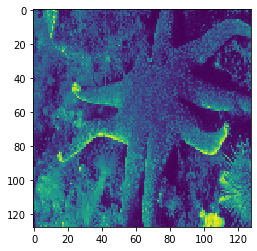

In [ ]:
plt.imshow( img_data[0])

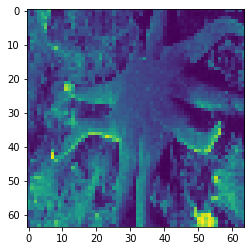

In [ ]:
plt.imshow( lr_data[0].reshape(64,64))

In [ ]:
upsaampling = tfk.Sequential([
    tfkl.InputLayer(input_shape=(64, 64,1)),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2DTranspose(32, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(64, 3, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(1, 3, strides=2,
                padding='same', activation=None),
])

upsaampling.summary()
upsaampling.load_weights('./checkpoints/upsaampling')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1)       577       
Total params: 19,905
Trainable params: 19,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_data[0].shape

(32, 32, 1)

In [ ]:
size = 64*64

In [ ]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=1,shape=(128,128))
    sigma = pm.HalfNormal('sigma', sd=10,shape=(128,128))
    
    y = pm.Normal('y', mu=mu, sd=sigma, observed=img_data)
    trace_g = pm.sample(100)

C:\Users\Hp\anaconda3\lib\site-packages\pymc3\sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2321 seconds.
The acceptance probability does not match the target. It is 0.42817552157443184, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6593717517415861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5269956888163346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6215025660048877, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
trace_g['mu'].shape

(2000, 64, 64)

In [ ]:
mean = trace_g['mu'][100:].mean(axis=0)
np.save("mean_sample", mean)

In [ ]:
sigma = trace_g['sigma'][100:].mean(axis=0)
np.save("sigma_sample.npy", sigma)

In [ ]:
sigma = tt._shared(np.load("sigma_sample.npy").astype("float64"))
mean = tt._shared(np.load("mean_sample.npy").astype("float64"))
#mean = tt._shared(upsaampling(lr_data[0].reshape(1,32,32, 1)).numpy().reshape(64,64).astype("float64"))

In [ ]:
mean_given = tt._shared(upsaampling(lr_data[0].reshape(1,64,64, 1)).numpy().reshape(128,128).astype("float64"))

In [ ]:
#np.save("mean_sample", mean)
#np.save("sigma_sample", sigma)

In [ ]:
downsampling = tfk.Sequential([
    tfkl.InputLayer(input_shape=(128, 128, 1)),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfkl.Conv2D(1, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
])
downsampling.summary()
downsampling.load_weights('./checkpoints/downsaampling')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 1)         26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@theano.compile.ops.as_op(itypes=[tt.dmatrix],otypes=[tt.dvector])
def downsamplemodel(x):    
    dec = (downsampling(np.array(x).reshape(1,128,128,1))).numpy().flatten().astype("float64")
    return dec


with pm.Model() as model:
    # Hidden variables
    
    #zs = pm.Normal("zs", mu=0, sigma=1, shape=(8,), dtype="float64", testval = z_int)         
    

    # Decoder and its parameters
    #dec = vae.decoder.predict(np.array([[zs[0], zs[1]]]))
    #decodermodel = decodermodel(zs)
    sig = pm.Gamma(name='sig',alpha = 3.0, beta = 1)
    # Observation model
    xs_ = pm.Normal(
        "xs_", mu=mean, sigma=sigma, dtype="float64", shape = (128,128), testval = mean_given)
    
    downsamplemodel = downsamplemodel(xs_)
    ys = pm.Normal(
        "ys", mu=downsamplemodel, sigma=sig, observed=lr_data[0].flatten())

In [ ]:
with model:       
        step = pm.Metropolis()
with model:
        # draw 500 posterior samples    
        trace = pm.sample(2000,step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [xs_]
>Metropolis: [sig]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [xs_]
>Metropolis: [sig]


C:\Users\Hp\anaconda3\lib\site-packages\pymc3\step_methods\metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
map_estimate = pm.find_MAP(model=model)

In [ ]:
trace['sig'][0]

0.057846749904552734

In [ ]:
mean_img = trace['xs_'][500:].mean(axis=0)

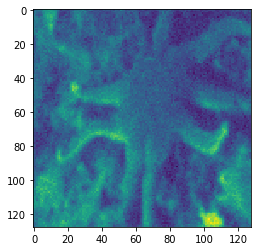

In [ ]:
plt.imshow(trace['xs_'][0])

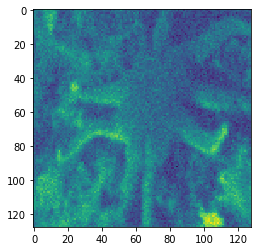

In [ ]:
plt.imshow(trace['xs_'][1000])

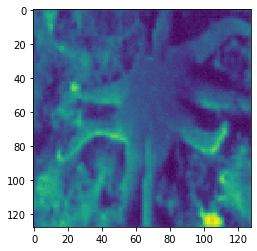

In [ ]:
plt.imshow(mean_img)

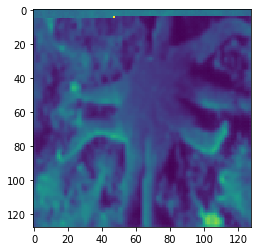

In [ ]:
plt.imshow(map_estimate['xs_'])

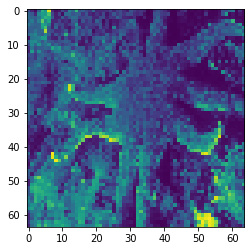

In [ ]:
plt.imshow(img_data[0].reshape(64,64))

In [ ]:
stretch_near = cv2.resize(lr_data[0], (128,128), interpolation=cv2.INTER_CUBIC)

In [ ]:
compare_psnr(img_data[0].reshape(128,128), mean_img)

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


21.16228127164185

In [ ]:
compare_psnr(img_data[0].reshape(128,128), stretch_near)

C:\Users\Hp\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


20.62824916852766

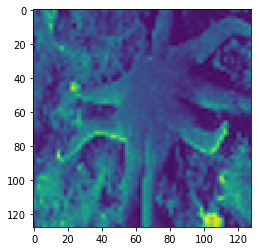

In [ ]:
plt.imshow(stretch_near)